# Segmentación de la señal para calcular biomarcadores de antisácadas

In [1]:
%matplotlib inline

import bsp.core
from bsp.core import load_study
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [14, 8]


study = load_study("data/20240420-rbg-antisaccade.bsp")
antisacade = study[1]

## Investigando direfencias de impulses y saccades
- Impulses: Utiliza KMeans --> separa movimientos rápidos de los lentos
- Saccades: Identifica las sácadas a partir de la velocidad y teniendo en cuenta la amplitud

In [2]:
from bsp.core import impulses
c = 0
for start, end in impulses(antisacade.hor_channel):
    #print("Impulso:", start/1000, end/1000) #segundos
    #print("Len(impulso): " , len(antisacade.hor_channel[start:end]))
    #print(antisacade.hor_channel[start:end])
    c += 1
print("Total impulsos: ", c)

Total impulsos:  40


In [3]:
from bsp.core.saccades import saccades
total_sacadas = 0
for onset, offset in saccades(antisacade.hor_channel, antisacade.angle, 0.2):
    total_sacadas += 1
    #print("Saccade onset:", onset, "Saccade offset:", offset)
print("Total sacadas" , total_sacadas)

Total sacadas 18


In [4]:
from bsp.core.differentiation import differentiate
from bsp.core.impulses import impulses

import numpy as np
from enum import Enum
from numpy import ndarray

def antisaccades(channel: np.ndarray, stimuli: np.ndarray) -> list[tuple[int, int]]:
    list = []
    samples_to_remove = 100
    stimuli = stimuli.copy()[:-samples_to_remove]
    amplitude_stimuli = abs(min(stimuli) - max(stimuli))
    c = 0
            
    for start, end in impulses(channel):
        amplitude_channel = max(abs(max(channel[start:end])), abs(min(channel[start:end]))) - min(abs(max(channel[start:end])), abs(min(channel[start:end])))
            
        if amplitude_channel > (amplitude_stimuli-1)/2:
            list.append((start, end))
            c += 1
    print(c)
    return list


17
[(3693, 3787), (5443, 5522), (7336, 7429), (9168, 9248), (10836, 10930), (12652, 12723), (14378, 14451), (16229, 16292), (17879, 17981), (21241, 21333), (23007, 23087), (24762, 24853), (26597, 26688), (28419, 28499), (31850, 31940), (33653, 33710), (35336, 35420)]
17


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


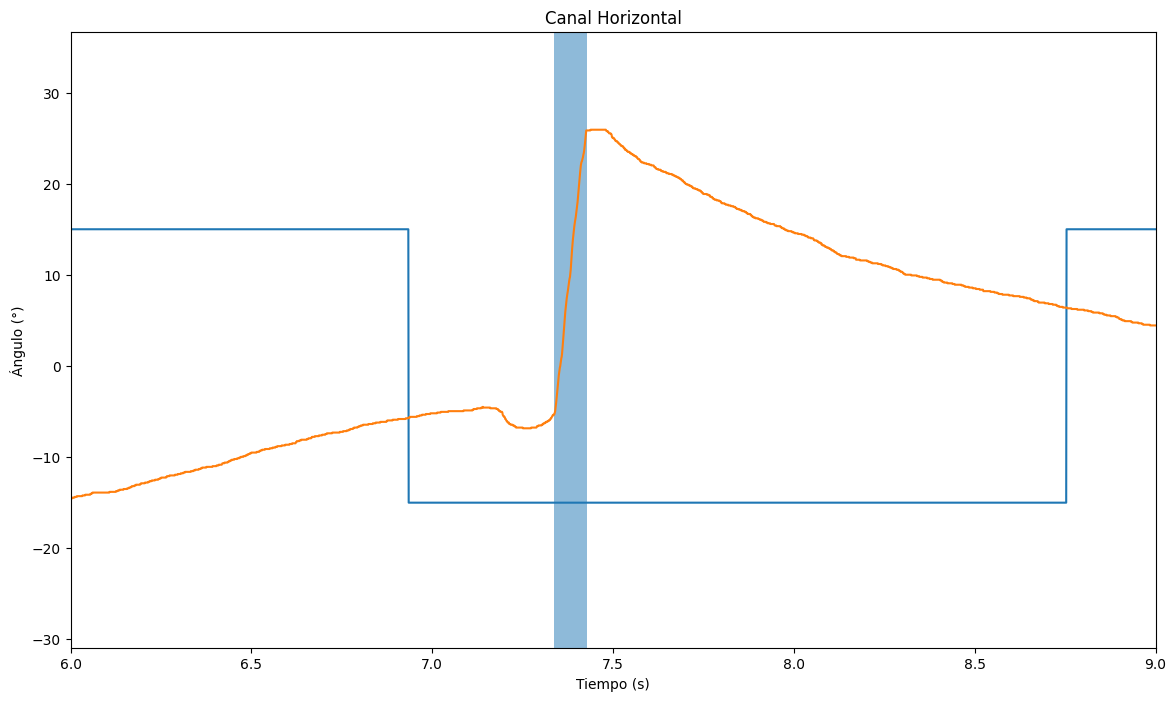

In [5]:
#from bsp.core.biomarkers import antisaccades

resultados = antisaccades(antisacade.hor_channel, antisacade.hor_stimuli)
print(resultados)

time = np.arange(len(antisacade.hor_stimuli)) / 1000.0  # segundos

plt.title("Canal Horizontal")
for start, end in antisaccades(antisacade.hor_channel, antisacade.hor_stimuli):
    plt.axvspan((start)/1000, (end)/1000, alpha=0.5)
plt.plot(time[0:37000], antisacade.hor_stimuli[0:37000])
plt.plot(time[0:37000], antisacade.hor_channel[0:37000])
plt.ylabel("Ángulo (°)");
plt.xlabel("Tiempo (s)")
plt.xlim(6,9)
plt.savefig("Antisácada.eps", format="eps")


(6.0, 8.0)

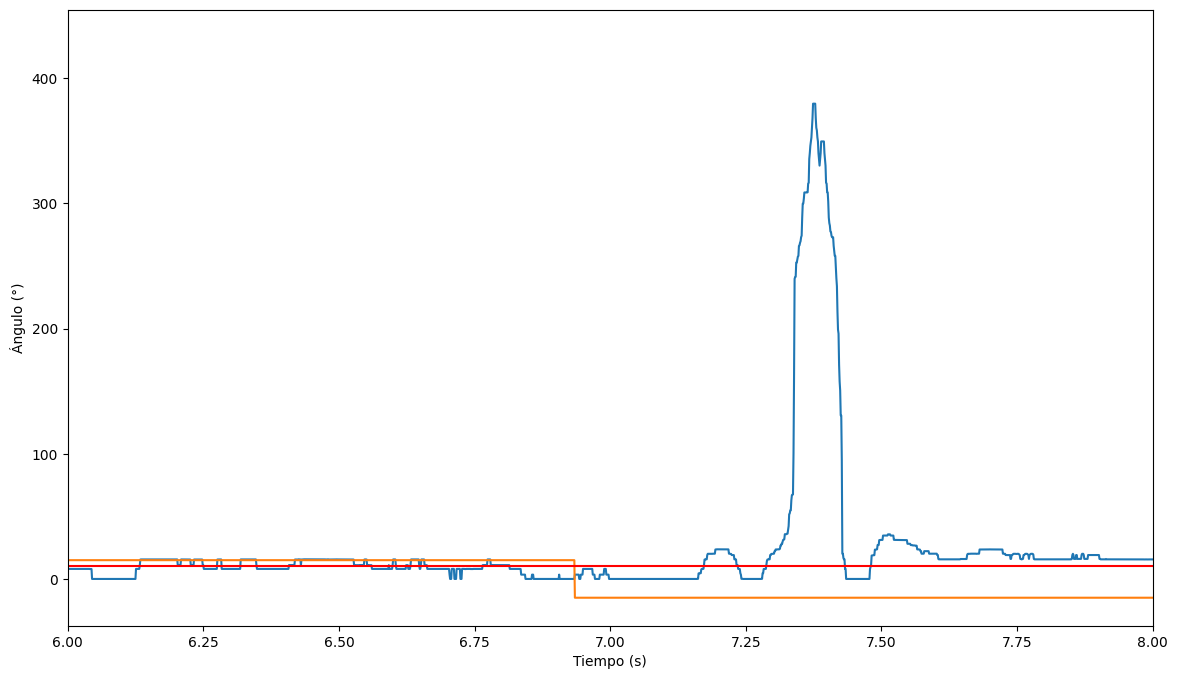

In [6]:
from scipy.signal import medfilt

plt.plot(time[0:37000], abs(medfilt(differentiate(antisacade.hor_channel[0:37000]), 71)))
plt.plot(time[0:37000], antisacade.hor_stimuli[0:37000])
plt.ylabel("Ángulo (°)");
plt.xlabel("Tiempo (s)")
plt.axhline(10, color='red')
plt.savefig("Umbra_Microsacada.eps", format="eps")
plt.xlim(6, 8)

## Detección sácadas

In [50]:
from bsp.core.differentiation import differentiate
from scipy.signal import medfilt

def saccades(channel: np.ndarray, changes_stimuli: list[int], antisaccades: list[tuple[int, int]]) -> list[tuple[int, int]]:
    list = []
    UMBRAL_VELOCIDAD_MICROSACADA = 10
    DURACION_MINIMA_MICROSACADA = 10
    DISTANCIA_MINIMA_DEL_ESTIMULO = 200
    velocities_abs = abs(denoise_01(differentiate(hor_channel_filter)))

    def identify_saccade(index: int) -> tuple[int, int] | None:
        left = index
        while left > 0 and velocities_abs[left - 1] >= UMBRAL_VELOCIDAD_MICROSACADA:
            left -= 1
        right = index
        while right < len(channel) - 1 and velocities_abs[right + 1] >= UMBRAL_VELOCIDAD_MICROSACADA:
            right += 1
        if right - left >= DURACION_MINIMA_MICROSACADA:
            return left, right
        return None

    for change_index in changes_stimuli:
        # Encontrar la próxima antisácada después de este cambio en el estímulo
        next_antisaccade_start = None
        for antisaccade_start, antisaccade_end in antisaccades:
            if antisaccade_start > change_index:
                next_antisaccade_start = antisaccade_start
                break
        in_saccade = False
        if next_antisaccade_start is not None:
            for idx in range(change_index, next_antisaccade_start):
                #print("change_index", change_index)
                if next_antisaccade_start - idx > 1000: # El impulso no corresponde con la antisácada
                    break
                
                if velocities_abs[idx] > UMBRAL_VELOCIDAD_MICROSACADA:
                    saccade = identify_saccade(idx)
                    if saccade:
                        list.append(saccade) 
                    
                    #if in_saccade == False:
                     #   start = idx
                     #   in_saccade = True
                        #print("next_antisaccade_start", next_antisaccade_start)
                        #print("saccade_start: ", start)
                    #if velocities_abs[idx + 1] < UMBRAL_VELOCIDAD_MICROSACADA:
                    #    end = idx
                     #   in_saccade = False
                        #print("next_antisaccade_start", next_antisaccade_start)
                        #print("Velocidad: ",velocities_abs[idx])
                        #print("Duracion: ", (end-start))
                        #print("Distacia con el estimulo: ", (start - change_index))
                        #print("***************")
                       # if (end - start) > DURACION_MINIMA_MICROSACADA and (start - change_index) > DISTANCIA_MINIMA_DEL_ESTIMULO:
                            #print("change_index", change_index)
                            #print("saccade_start: ", start)
                            #print("saccade_end: ", end)
                            #print("Velocidad: ",velocities_abs[idx])
                            #print("Duracion: ", (end-start))
                            #print("Distacion con el estimulo: ", (start - change_index))
                            #print("---------------------")
                          #  list.append((start, end))  
    return list

In [51]:
def detect_changes(stimuli: np.ndarray) -> list[int]:
    change_indices = []
    for i in range(1, len(stimuli)):
        if stimuli[i] != stimuli[i - 1]:
            change_indices.append(i)
    return change_indices

[(3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411

(0.0, 37.0)

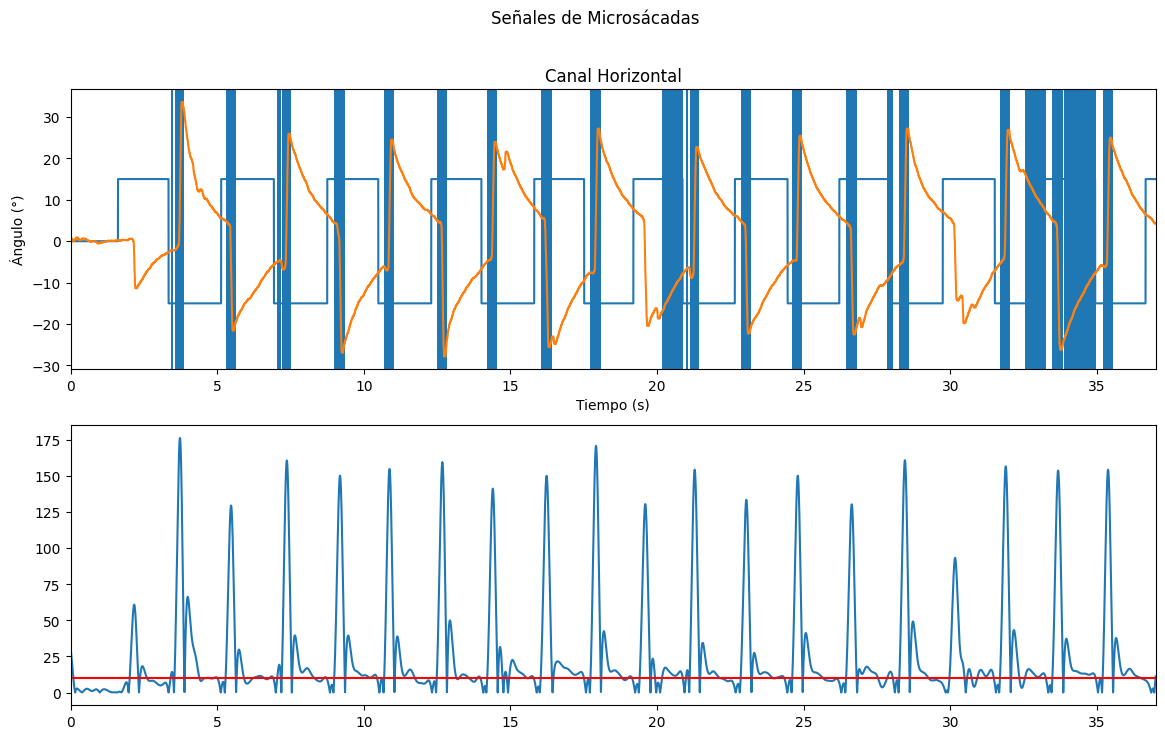

In [52]:
from scipy import signal
def denoise_35(value: np.ndarray) -> np.ndarray:
    # Hacemos un filtrado agresivo ya que lo que nos interesa es la forma de onda 
    # en general de la señal para identificar el desfase
    b, a = signal.butter(3, 0.035)
    y = signal.filtfilt(b, a, value)
    return y

def denoise_01(value: np.ndarray) -> np.ndarray:
    # Hacemos un filtrado agresivo ya que lo que nos interesa es la forma de onda 
    # en general de la señal para identificar el desfase
    b, a = signal.butter(3, 0.005)
    y = signal.filtfilt(b, a, value)
    return y
    
hor_channel_filter = denoise_35(antisacade.hor_channel_raw * study.hor_calibration)
sacadas = saccades(hor_channel_filter, detect_changes(antisacade.hor_stimuli), resultados)
#print(sacadas)
#print(len(sacadas))

plt.suptitle("Señales de Microsácadas")

plt.subplot(211)
plt.title("Canal Horizontal")
for start, end in sacadas:
#for start, end in saccades(antisacade.hor_channel, antisacade.angle, 0.2):
    plt.axvspan((start)/1000, (end)/1000, alpha=1)
plt.plot(time, antisacade.hor_stimuli)
plt.plot(time, antisacade.hor_channel)
plt.ylabel("Ángulo (°)");
plt.xlabel("Tiempo (s)")
plt.xlim(0, 37)  # Limitar el eje x
plt.savefig("Detección_Microsácadas.eps", format="eps")

plt.subplot(212)
velocities_abs = abs(denoise_01(differentiate(hor_channel_filter)))
plt.plot(time, velocities_abs)
plt.axhline(10, color='red')
plt.xlim(0, 37)


(20.0, 22.0)

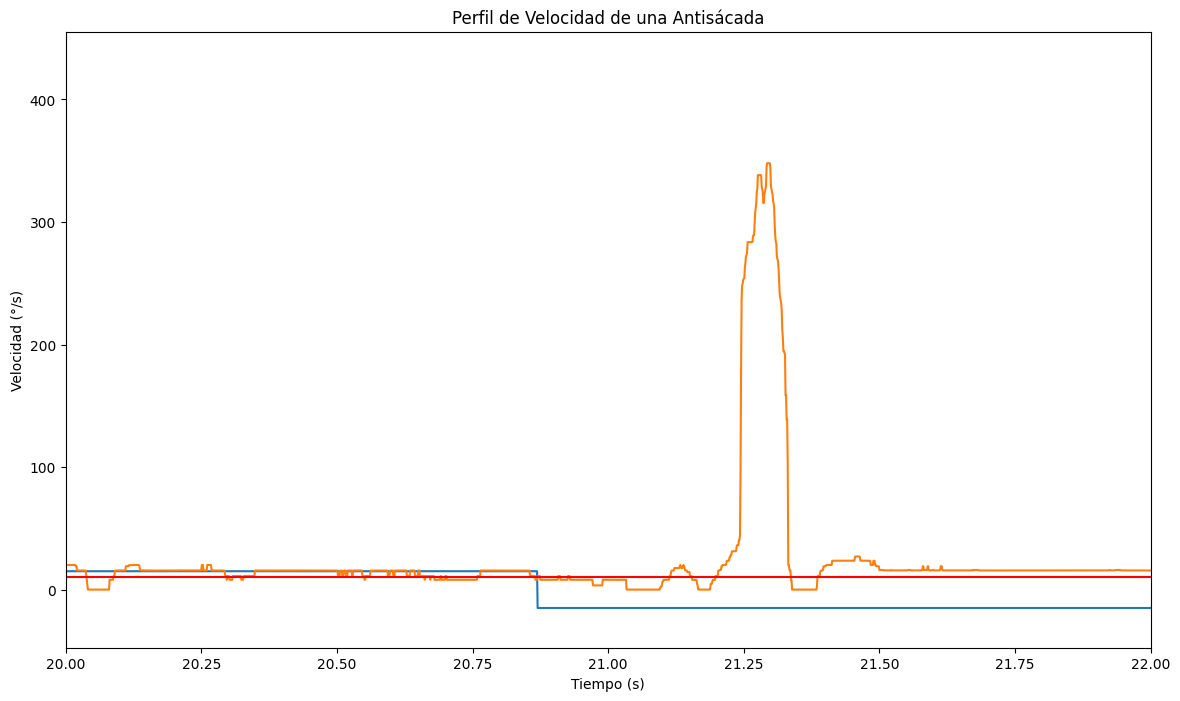

In [10]:
plt.title("Perfil de Velocidad de una Antisácada")
plt.plot(time, antisacade.hor_stimuli)
plt.plot(time, abs(medfilt(differentiate(antisacade.hor_channel), 71)))
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (°/s)");
plt.axhline(10, color='red')
plt.xlim(20, 22)

In [11]:
def detect_saccades(channel: np.ndarray, change_indices: list[int], antisaccades: list[tuple[int, int]]) -> list[tuple[int, int]]:
    saccades = []
    window = 40  # Tamaño de la ventana para determinar la dirección del cambio

    for change_index in change_indices:
        # Encontrar la próxima antisácada después de este cambio en el estímulo
        next_antisaccade_start = None
        for antisaccade_start, antisaccade_end in antisaccades:
            if antisaccade_start > change_index:
                next_antisaccade_start = antisaccade_start
                break

        if next_antisaccade_start is not None: # Buscar por velocidad
            # Buscar el cambio en el canal ocular entre el cambio de estímulo y la próxima antisácada
            for idx in range(change_index, next_antisaccade_start):
                if next_antisaccade_start - idx > 1000: # El impulso no corresponde con la antisácada
                    break
                if idx >= window and idx < len(channel):
                    pre_change_direction = np.sign(channel[idx] - channel[idx - window])
                    post_change_direction = np.sign(channel[idx + window] - channel[idx])
                    if pre_change_direction != post_change_direction:
                        print("idx: ", idx)
                        #print("next_antisaccade_start: ", next_antisaccade_start)
                        # Buscar el punto donde la señal vuelve a la dirección pre-cambio
                        for j in range(idx, next_antisaccade_start):
                            if np.sign(channel[j] - channel[idx]) == pre_change_direction:
                                saccades.append((idx, j))
                                break

    return saccades


In [12]:
sacadas = saccades(antisacade.hor_channel, detect_changes(antisacade.hor_stimuli), resultados)
print(sacadas)

[(7173, 7235), (10715, 10762), (21113, 21154)]


Text(0.5, 0, 'Tiempo (s)')

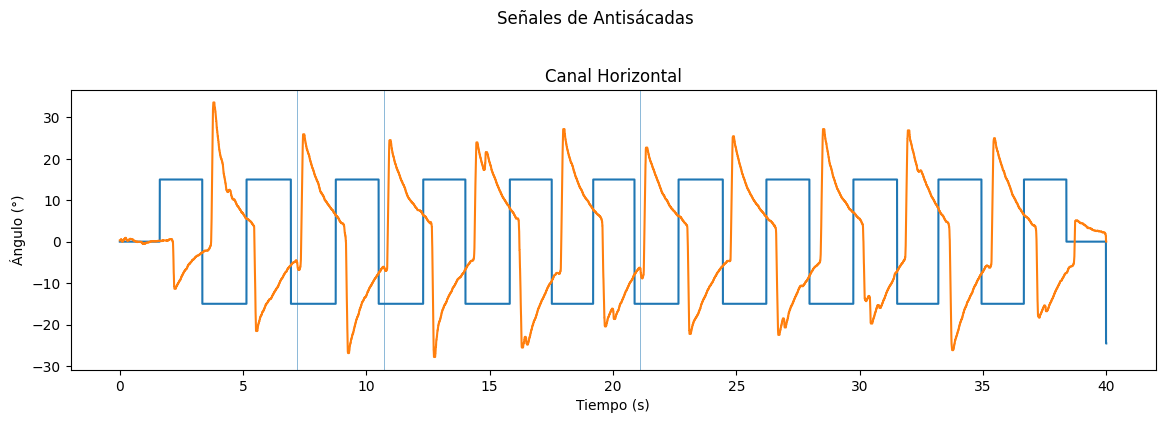

In [13]:
plt.suptitle("Señales de Antisácadas")

plt.subplot(211)
plt.title("Canal Horizontal")
for start, end in sacadas:
#for start, end in saccades(antisacade.hor_channel, antisacade.angle, 0.2):
    plt.axvspan((start)/1000, (end)/1000, alpha=0.5)
plt.plot(time, antisacade.hor_stimuli)
plt.plot(time, antisacade.hor_channel)
plt.ylabel("Ángulo (°)");
plt.xlabel("Tiempo (s)")
#plt.xlim(6, 8)  # Limitar el eje x de 0 a 5 segundos


## Dirección
| Celda 1 | Stimuli + | Stimuli - |
|---------|---------|---------|
| Channel + | Sácada Derecha | Antisácada Derecha |
| Channel - | Antisácada Izq | Sácada Izq |

In [14]:
class Direction(Enum):
    Left = "left"
    Right = "right"
    
def direction(channel: np.ndarray, stimuli: np.ndarray, start: int, end: int) -> Direction:
    if channel[end] > 0:
        if stimuli[end] > 0:
            # Sacada Derecha
            return Direction.Right
        elif stimuli[end] < 0:
            # Antisácada Derecha
            return Direction.Right
    elif channel[end] < 0:
        if stimuli[end] > 0:
            # Antisácada Izquierda
            return Direction.Left
        elif stimuli[end] < 0:
            # Sácada Izquierda
            return Direction.Left
        

In [15]:
direccion = direction(antisacade.hor_channel, antisacade.hor_stimuli, 3691, 5522)
print(direccion)

Direction.Left


## Latencia antisacádica
$$\text{Latencia antisacádica} = (X_{\text{inicio antisácada}} - X_{\text{inicio estímulo}}) \times \text{Intervalo de muestras}$$

In [16]:
def detect_changes(stimuli: np.ndarray) -> list[int]:
    change_indices = []
    for i in range(1, len(stimuli)):
        if stimuli[i] != stimuli[i - 1]:
            change_indices.append(i)
    return change_indices

# Ejemplo de uso
estimulo = np.array([0, 15, 15, -15, -15, -15, 15, 15, 15])
cambios = detect_changes(antisacade.hor_stimuli)
print("Cambios en los índices:", cambios)

Cambios en los índices: [1617, 3342, 5135, 6935, 8754, 10494, 12300, 14012, 15812, 17514, 19193, 20870, 22654, 24452, 26216, 27963, 29744, 31518, 33192, 34940, 36660, 38383, 39988]


In [17]:
movements = antisaccades(antisacade.hor_channel, antisacade.hor_stimuli)
print(movements)

17
[(3693, 3787), (5443, 5522), (7336, 7429), (9168, 9248), (10836, 10930), (12652, 12723), (14378, 14451), (16229, 16292), (17879, 17981), (21241, 21333), (23007, 23087), (24762, 24853), (26597, 26688), (28419, 28499), (31850, 31940), (33653, 33710), (35336, 35420)]


In [18]:
def antisaccade_latencies_biomarker(stimuli: np.ndarray, movements: list[tuple[int, int]]) -> list[float]:
    
    def detect_changes(stimuli: np.ndarray) -> list[int]:
        change_indices = []
        for i in range(1, len(stimuli)):
            if stimuli[i] != stimuli[i - 1]:
                change_indices.append(i)
        return change_indices
    
    latencies = []
    SAMPLES_INTERVAL = 1/1000
    stimuli_changes = detect_changes(stimuli)
    for start, end in movements:
        last_stimuli = max(change for change in stimuli_changes if change < start)
        latency = (start - last_stimuli) * SAMPLES_INTERVAL
        latencies.append(latency)
    return latencies
    

In [19]:
latencias = antisaccade_latencies_biomarker(antisacade.hor_stimuli, movements)
print(latencias)

[0.35100000000000003, 0.308, 0.401, 0.41400000000000003, 0.342, 0.352, 0.366, 0.417, 0.365, 0.371, 0.353, 0.31, 0.381, 0.456, 0.332, 0.461, 0.396]


In [20]:
def detect_changes(stimuli: np.ndarray) -> list[int]:
        change_indices = []
        for i in range(1, len(stimuli)):
            if stimuli[i] != stimuli[i - 1]:
                change_indices.append(i)
        return change_indices

In [21]:
stimuli_changes = detect_changes(antisacade.hor_stimuli)
print(stimuli_changes)

[1617, 3342, 5135, 6935, 8754, 10494, 12300, 14012, 15812, 17514, 19193, 20870, 22654, 24452, 26216, 27963, 29744, 31518, 33192, 34940, 36660, 38383, 39988]


## Duración
$$\text{Duración} = (X_{\text{fin antisácada}} - X_{\text{inicio antisácada}}) \times \text{Intervalo de muestras}$$

In [22]:
def antisaccade_durations_biomarker(movements: list[tuple[int, int]]) -> list[float]:
    durations = []
    samples_interval = 1/1000
    for start, end in movements:
        duration = (end - start) * samples_interval
        durations.append(duration)
    return durations

In [23]:
durations = antisaccade_durations_biomarker(movements)
print(durations)

[0.094, 0.079, 0.093, 0.08, 0.094, 0.07100000000000001, 0.073, 0.063, 0.10200000000000001, 0.092, 0.08, 0.091, 0.091, 0.08, 0.09, 0.057, 0.084]


## Velocidad máxima
No aplico filtro a la velocidad , debería?

In [24]:
from bsp.core.differentiation import differentiate

def antisaccade_velocities_biomarker(channel: np.ndarray, movements: list[tuple[int, int]]) -> list[float]:
    velocities = []
    for start, end in movements:
        velocidad_max = max(abs(differentiate(channel[start:end])))
        velocities.append(velocidad_max)
    return velocities

In [25]:
velocities = antisaccade_velocities_biomarker(antisacade.hor_channel, movements)
print(velocities)

[682.4516809162653, 586.6943372713102, 600.7606570074146, 598.4162947144172, 543.0628295637604, 736.8616691002478, 596.1022995753907, 513.1020523729302, 585.7498595764587, 624.2512345036149, 579.4933981550879, 555.6984999981979, 536.5926643258949, 527.8693156920391, 567.0860908526085, 593.8494229557539, 528.6759818906272]


## Location in memory
$$\text{Precisión de la localización del estímulo en memoria} = \frac{\text{Amplitud del estímulo}-\text{Amplitud de la antisácada}}{\text{Amplitud del estímulo}}$$

$$\text{Amplitud de la antisácada} = \left| Y_{\text{fin antisácada}} - Y_{\text{inicio antisácada}} \right|$$

In [26]:
def antisaccade_location_memory_biomarker(channel: np.ndarray, stimuli: np.ndarray, antisaccades_movements:list[tuple[int, int]]) -> list[float]:
    accuracy_locations_memory = []
    amplitude_stimuli = abs(min(stimuli) - max(stimuli))

    for start, end in antisaccades_movements:
        amplitude_channel = max(abs(max(channel[start:end])), abs(min(channel[start:end]))) - min(abs(max(channel[start:end])), abs(min(channel[start:end])))
        location_memory = (amplitude_stimuli - amplitude_channel)/amplitude_stimuli
        accuracy_locations_memory.append(location_memory)
    return accuracy_locations_memory

In [27]:
loc = antisaccade_location_memory_biomarker(antisacade.hor_channel, antisacade.hor_stimuli, movements)
print(loc)

[0.16930428, 0.5514274, 0.48219022, 0.32868114, 0.5534808, 0.43459022, 0.4425844, 0.5425527, 0.48615095, 0.6247713, 0.5613288, 0.47228876, 0.5435062, 0.4663479, 0.4663479, 0.48805806, 0.59704715]


## Inhibición de la respuesta
$$\text{Inhibición de la respuesta} = \frac{\text{Total sácadas inapropiadas}}{\text{Total antisácadas}}$$

In [28]:
def antisaccade_response_inhibition_biomarker(saccades_movements: list[tuple[int, int]], antisaccades_movements: list[tuple[int, int]]) -> float:
    print(len(saccades_movements))
    print(len(antisaccades_movements))
    return len(saccades_movements)/len(antisaccades_movements)

In [29]:
inhibition_biomarker = antisaccade_response_inhibition_biomarker(sacadas, movements)
print(inhibition_biomarker)

3
17
0.17647058823529413


## Latencia Antisacádica Correctora 
$$\text{Latencia antisacádica correctora} = (X_{\text{inicio antisácada}} - X_{\text{fin microsácada}}) \times \text{Intervalo de muestras}$$

In [30]:
def antisaccade_correction_latencies_biomarker(saccades_movements: list[tuple[int, int]], antisaccades_movements: list[tuple[int, int]]) -> list[float]:
    SAMPLES_INTERVAL = 1/1000
    correction_latencies = []
    
    for start_microsaccade, end_microsaccade in saccades_movements:
        next_antisaccade_start = None
        for start_antisaccade, end_antisaccade in antisaccades_movements:
            if start_antisaccade > end_microsaccade:
                print("start_antisaccade", start_antisaccade)
                print("end_microsaccade",end_microsaccade)
                print("diferencia", (start_antisaccade - end_microsaccade))
                print("---------------------")
                next_antisaccade_start = start_antisaccade
                break
        if next_antisaccade_start is not None:
            correction_latencies.append((start_antisaccade - end_microsaccade)*SAMPLES_INTERVAL)
    return correction_latencies

In [31]:
correction_latencies = antisaccade_correction_latencies_biomarker(sacadas, movements)
print(correction_latencies)

start_antisaccade 7336
end_microsaccade 7235
diferencia 101
---------------------
start_antisaccade 10836
end_microsaccade 10762
diferencia 74
---------------------
start_antisaccade 21241
end_microsaccade 21154
diferencia 87
---------------------
[0.101, 0.074, 0.08700000000000001]


# Implementación dataclass

In [ ]:
@dataclass
class AntissaccadeBiomarkers:
    latency: float
    location_memory: float
    peak_velocity: float
    duration: float
    correction_latency: float

@dataclass
class AntissaccadicBiomarkers:
    antisaccades: list[AntissaccadeBiomarkers]
    latency_mean: float
    latency_std: float
    location_memory_mean: float
    location_memory_std: float
    peak_velocity_mean: float
    peak_velocity_std: float
    duration_mean: float
    duration_std: float
    correction_latency_mean: float
    correction_latency_std: float
    response_inhibition: float

class Direction(Enum):
    Left = "left"
    Right = "right"

In [ ]:
def antissacadic_biomarkers(channel: np.ndarray, stimuli: np.ndarray) -> AntissaccadicBiomarkers:
    antisaccades_movements = antisaccades(channel, stimuli)
    saccades_movements = saccades(channel, stimuli, antisaccades_movements)

    latencies = antisaccade_latencies_biomarker(stimuli, antisaccades_movements)
    inhibition = antisaccade_response_inhibition_biomarker(saccades_movements, antisaccades_movements)
    location_memory = antisaccade_location_memory_biomarker(channel, stimuli, antisaccades_movements)
    velocities = antisaccade_velocities_biomarker(channel, antisaccades_movements)
    durations = antisaccade_durations_biomarker(antisaccades_movements)
    correction_latencies = antisaccade_correction_latencies_biomarker(saccades_movements, antisaccades_movements)
